In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from IPython.display import display
import statsmodels.api as sm

# 5. CLM假设误差分析

结束了前四章的学习，大家基本上掌握了回归分析中比较重要的知识了。我们简单回顾一下前面所学内容：

1. 第一章，我们学习了回归的基本思想，并介绍了本课程中最重要、最常用的模型——多元线性回归模型。
2. 第二章，我们介绍了多元线性回归模型的基本六大假设——CLM假设，OLS最小二乘估计法并学习了在这套假设下的性质。需要注意的是，后面两章的内容均建立这些OLS性质上，我们需要时刻牢记这一点。
3. 第三章，我们学习了回归分析中最重要的分析任务之一——模型的统计推断，介绍了回归分析中各种类型的假设检验。
4. 第四章，我们对线性模型进行了拓展，将回归元从定量变量一次项拓展至定性变量、对数项、二次项、交互项，使模型蕴含的信息更丰富。

然而，以上内容均建立在模型严格满足CLM假设的前提下，一旦模型违背了CLM假设中的某一条假设，模型估计的精度、假设检验的可信度将受到影响。那么，违反某条CLM假设具体会给模型估计带来多大的影响呢？这就是本节需要讨论的内容。

## 5.1 OLS估计另一种更为常用的求解方法

我们在前面的章节中给出了OLS估计系数求解的矩阵表达式
$$
\hat{\beta}=\left(X^{\prime} X\right)^{-1} X^{\prime} y
$$
并给出了每个估计系数$\hat{\beta_j}$估计标准误的矩阵表达式
$$
\operatorname{se}\left(\hat{\beta}_{j}\right)=\hat{\sigma} \sqrt{\left(X^{\prime} X\right)_{j+1, j+1}^{-1}}
$$
矩阵表达式的一大好处就是方便求解，直接矩阵运算就完事了。但是这并不利于我们观察它们的“构成”——如果我想知道系数的估计标准误受什么因素影响，并从此获知降低误差的方法，那么面对上面这个只有设计阵$X$的公式，我们只能阿巴阿巴。

好在OLS估计确实有另一种求法，且这种求法得来的公式可以满足我们这一需求，接下来就让我们简单介绍一下这种求法，并用它来总结出系数估计方差的影响因素吧！

### 5.1.1 解法步骤

该部分仅作了解即可。

我们以求回归模型
$$
y=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}+u
$$
中$\beta_1$为例，大体上可分为两步

**· step 1**，以$x_1$做因变量，对其他自变量做回归
$$
x_{1}=\alpha_{0}+\alpha_{2} x_{2}+\cdots+\alpha_{k} x_{k}+r_{1}
$$
记残差为$\hat{r}_{1}=\left(\hat{r}_{11}, \hat{r}_{21}, \cdots, \hat{r}_{n 1}\right)^{\prime}$

**· step 2**，$y$对残差$\hat{r}_{1}$做过原点（无截距）的回归
$$
y=\gamma \hat{r}_{1}+u
$$
可以证明，$\beta_1$的估计就是$\hat{y}$
$$
\hat{\gamma}=\hat{\beta}_1=\frac{\sum_{i=1}^n{\hat{r}_{i1}}y_i}{\sum_{i=1}^n{\hat{r}_{i1}^{2}}}
$$
我们仔细品味一下$\beta_1$的求解过程，会发现它非常符合我们对回归模型系数的理解——在第一步的自变量回归中，残差$\hat{r}_{1}$相当于是在$x_1$中排除了$x_2$,……,$x_n$影响后的剩余部分，因此$\hat{\beta}_1$相当于在度量排除了其余自变量影响后，$x_1$对$y$的影响。而我们回想一下之前我们对$\beta_1$的解释有一个重要的前置语：“在其他自变量不变的前提下”，这恰恰就是排除其他变量的影响的含义。

我们用python实操一波，看看这种求解方法的结果和之前的求解方法是否一致。

In [11]:
gpa1=pd.read_stata('./data/gpa1.dta')
# 常规解法的结果
gpa_lm1=sm.formula.ols('colGPA~ACT+hsGPA',data=gpa1).fit()
print('常规解法的结果:')
print(gpa_lm1.params[1])
print('-------------------------------------------')

# 新求解法
gpa_lm2_pre=sm.formula.ols('ACT~hsGPA',data=gpa1).fit()
gpa1['resid']=gpa_lm2_pre.resid
gpa_lm2_pre2=sm.formula.ols('colGPA~resid-1',data=gpa1).fit()
print('新解法的效果')
print(gpa_lm2_pre2.params[0])

常规解法的结果:
0.009426012260472932
-------------------------------------------
新解法的效果
0.009426012260473621


可见，两种解法是完全等价的。

### 5.1.2 估计系数的方差构成与多重共线性

在MLR.1~MLR.5下，$\operatorname{Var}\left(\hat{\beta}_{1}\right)$可计算为
$$
\operatorname{Var}\left(\hat{\beta}_{1}\right)=\frac{\sigma^{2}}{\sum_{i=1}^{n} \hat{r}_{i 1}^{2}}=\frac{\sigma^{2}}{S S T_{1}\left(1-R_{1}^{2}\right)}
$$
其中，$S S T_{1}=\sum_{i=1}^{n}\left(x_{i 1}-\bar{x}_{1}\right)^{2}$为$x_1$变量本身的完全平方和，$R_{1}^{2}$是$x_1$对其他解释变量所作回归的拟合优度判决系数，$\sigma^{2}$则是之前提及的随机误差的方差。至此，回归系数估计方差的构成就结构完毕了，它依赖于三个因素：

**· 误差方差$\sigma^{2}$**，随机误差的方差可以理解为数据集的噪声信息，噪声信息越多，估计的不确定性就越大，方差就越大，这点很顺理成章！但是一般来说，对于给定的数据集，误差方差也是随之确定的，我们一般不会在这个因素上下文章。

**· 自变量$x_1$本身的总变异$SST_1$**，自变量总变异越大，表明自变量散步程度越高，估计越牢靠。关于这个指标，我们会发现：对于一个分析任务来说，样本量越大，总变异也就越大，进而估计方差会变小，这告诉我们更多的随机样本有利于提高估计的精度！

**· 自变量间的线性关联程度$R_{1}^{2}$**，$R_{1}^{2}$约接近1，$x_1$与其他自变量之间的线性关系就越强烈，估计方差也越大。这种近似的共线性关系被称为**多重共线性(multicolinearity)**，它不同于完全共线性（事实上$R_{1}^{2}=1$时就是完全共线性），这种现象在数据分析中普遍存在，只是程度有所区别。那么如何衡量共线性的严重程度呢？我们一般用方差膨胀因子(VIF,Variance Inflation Factor)来评判
$$
VIF_{x1}=\frac{1}{1-R_{1}^{2}}
$$
若$VIR>10$，意味着共线性很严重，需要采取措施降低共线性。

现在的问题是，如何降低多重共线性呢？一种方法是使变量之间尽可能的不相关，关于这点我们可以查看变量之间的皮尔逊相关系数，如果某两个变量之间的相关系数非常高，我们就需要考虑不把它们同时放入模型中；第二种方法是减少自变量的个数。一般而言，模型中自变量个数越多，R方会越大。而$R_{1}^{2}$正是$x_1$对其他自变量做回归的判决系数，显然，其他自变量越多，$R_{1}^{2}$就越大。这个方法告诉我们，**模型的自变量绝非越多越好**，有关这个问题的讨论，我们会在下一节做深入探讨。

最后，我们总结一下降低估计方差，提高估计精度的方法

1. 采取更合理的数据采样方法，降低数据噪声。
2. 增大数据样本量
3. 根据线性相关程度筛选纳入模型的变量，且切忌纳入过多变量。

## 5.2 模型误设的误差分析——违反MLR.1的后果是什么

### 5.2.1 如何理解模型误设

在MLR.1中，我们假设自己设置的模型是“正确的”，即对
$$
y=\beta_{0}+\beta_{1} x_{1}+\beta_{2} x_{2}+\cdots+\beta_{k} x_{k}+u
$$
的假设上，我们正确地纳入了所有关键的自变量，且没有纳入多余的自变量。而多纳入一个无关的变量，以及少纳入一个关键的变量，都能算是违反MLR.1，我们可以看看误设模型对模型中变量系数的估计会有怎样子的影响。

### 5.2.2 模型误设的后果

**· 遗漏相关变量**

假设真模型为
$$
y \sim x_{1}+x_{2}+\cdots+x_{k-1}+x_{k}
$$
但我们实际拟合的模型却是
$$
y \sim x_{1}+x_{2}+\cdots+x_{k-1}
$$
假设真模型的系数估计记为$\hat{\beta}_{i}$，实际模型的系数估计为$\tilde{\beta}_{i}$，那么有
$$
\tilde{\beta}_{1}=\hat{\beta}_{1}+\hat{\beta}_{k} \tilde{\delta}_{1}
$$
其中，$\tilde{\delta}_{1}$是遗漏变量对其余变量的辅助回归$x_{k} \sim x_{1}+x_{2}+\cdots+x_{k-1}$中$x_1$对应的回归系数。我们观察一下$\tilde{\beta}_{1}$的无偏性情况
$$
E\left(\tilde{\beta}_{1} \mid x\right)=\beta_{1}+\beta_{k} \tilde{\delta}_{1}
$$
发现，原本正确模型假设下的无偏性$E\left( \hat{\beta}_1 \right) =\beta _1$，因漏设相关变量$x_k$导致多了偏差$\beta_{k} \tilde{\delta}_{1}$。

因此，对于遗漏变量$x_k$，除非$\beta_k=0$（即$x_k$对$y$完全不影响），或者$\tilde{\delta}_{1}=0$（遗漏变量$x_k$与待分析自变量$x_1$不相关），否则遗漏变量会对我们实际估计模型的系数估计产生有偏影响，即我们的系数估计不再是平均意义上的准确！

**· 多纳入一个无关变量**

假设真模型为
$$
y \sim x_{1}+x_{2}+\cdots+x_{k-1}
$$
但实际拟合的模型是
$$
y \sim x_{1}+x_{2}+\cdots+x_{k-1}+x_{k}
$$
且：$x_k$与其余自变量$x_i$存在相关性，但与因变量$y$不存在相关性（即无法对因变量变异做出解释），此时，我们实际拟合的模型相当于是
$$
y=\beta _0+\beta _1x_1+\cdots +\beta _{k-1}x_{k-1}+0x_k+u
$$
这种过度设定**其实并不违反MLR.1-MLR.4中的任意一条**，因为就算将这个无关变量纳入模型，最终拟合出来的变量对应系数也会是0。因此，纳入无关变量这种情况对于建立在前四个假设上的OLS无偏性是没有影响的！即依然有
$$
E\left( \widetilde{\beta _i} \right) =\beta _i
$$
但是只要$x_k$与其它自变量存在共线性，将其纳入会使其他系数的估计方差变大。以$x_1$的系数为例，假设纳入$x_k$前它的方差是
$$
\mathrm{Var}\left( \hat{\beta}_1 \right) =\frac{\sigma ^2}{SST_1\left( 1-R_{1,k-1}^{2} \right)}
$$
而纳入$x_k$后它的方差就变成了
$$
\mathrm{Var}\left( \tilde{\beta}_1 \right) =\frac{\sigma ^2}{SST_1\left( 1-R_{1,k}^{2} \right)}
$$
由于而多自变量的模型R方总是大于少自变量模型的R方，即
$$
R_{1,k-1}^{2}<R_{1,k}^{2}
$$
于是最终有
$$
\mathrm{Var}\left( \hat{\beta}_1 \right) <\mathrm{Var}\left( \tilde{\beta}_1 \right) 
$$
因此，对于增加一个**对解释因变量无益**的自变量，一旦这个无益自变量与其它自变量存在共线性，则会增大其他估计系数的估计方差！

### 5.2.3 变量选择的方法论

我们总结一下以上的内容：

1. 减少模型中的变量，可能会导致模型其他系数的估计有偏，但是会使系数估计的方差减少，即：增大偏差、减小方差
2. 增加模型中的变量，不会导致模型系数估计有偏，但是会使系数估计的方差增大，即：减小偏差、增大方差

而在实际情况中，我们不可能得知一个真正正确的模型，而是在摸索中慢慢找到适合纳入模型的变量。通常来说，有两种考量纳入变量的方法论：

1. 从少数变量开始，一步步向模型纳入我们认为重要的变量，并通过t检验显著性来判断是否纳入该变量；如果我们认为变量存在二次项效应与交互项效应，可以将其纳入模型并通过联合F检验判断其显著性，直到模型的解释度达到一个较高的水平。
2. 从多数变量开始，一步步将不显著的变量剔除出模型。

这两种方法该用哪一种，视具体情况而定。假若数据集的变量非常多，那我倾向于使用第一种方法，一步步将我们认为重要的变量纳入模型；若变量不多，则第二种方法可以考虑。

对于变量的选择，还有一些自动化的方法，如向前逐步选择、向后逐步选择等等。但我个人认为，这些自动的变量选择方法更关注模型的预测能力，而不注重变量本身对模型的意义，它们更适用于机器学习的预测任务，而不适用于回归分析，因为回归分析中最重要的意义就是“解释与推断”。

## 5.3 模型不满足正态性的分析——违反MLR.6的后果是什么

**提前公布答案：在样本量较大的情况下，不满足MLR.6不会有什么不好的后果！**

### 5.3.1 如何理解与观测正态性假设

我们先回顾一下MLR.6：该假设假定随机误差$u$在任何自变量$x$已知的条件下服从正态分布
$$
u \mid x \sim N\left(0, \sigma^{2}\right)
$$
即每个样本的误差$u_1,u_2,...,u_n$都是来源于一个正态总体。然而，随机误差在数据集中是根本观测不到的，而由于在$x$已知的条件下，$u$的正态性等价于$y$的正态性，因此我们只需要查看样本因变量$y$的分布图就可以大致判断正态性了。

然而，因变量$y$不为正态分布的情况是非常常见的，以下面的$narr86$为例，它统计了青年人在某一特定年份被拘捕的次数。很明显，绝大部分青年人都没有被拘捕过，因此该变量的分布是一个严重的偏态分布，不可能为正态分布。


0.0     1970
1.0      559
2.0      121
3.0       42
5.0       13
4.0       12
6.0        4
12.0       1
9.0        1
10.0       1
7.0        1
Name: narr86, dtype: int64


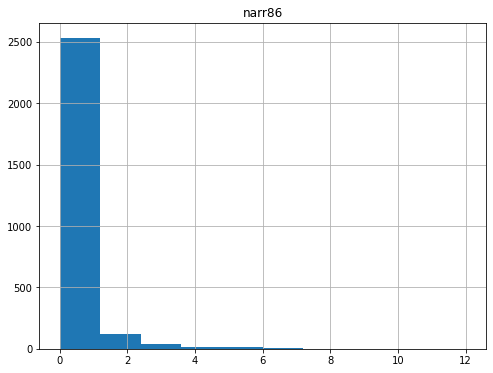

In [12]:
# 频数直方图
crime1=pd.read_stata('./data/crime1.dta')
crime1.hist(column='narr86',figsize=(8,6))
print(crime1.narr86.value_counts())

那么，如果将其作为因变量$y$构建模型，会发生什么后果呢？

### 5.3.2 违背正态性假设的后果

我们知道，在MLR.1-MLR.5下，OLS估计具有最优线性无偏估计的性质，这一性质不需要满足正态性假设MLR.6，因此**违背正态性假设不会影响OLS系数估计的准确性与稳定性**。

但是我们在进行假设检验的时候，基于t统计量与F统计量的推断是以满足MLR.6为前提的，这是否意味着对于narr86这种因变量而言，我们无法对其进行t检验与F检验呢？幸运的是，回答是否定的。得益于**中心极限定理**，我们有下述定理成立

**· 定理：** 在MLR.1-MLR.5假定下，OLS估计系数的抽样分布满足
$$
\frac{\hat{\beta}_{j}-\beta_{j}}{\operatorname{se}\left(\hat{\beta}_{j}\right)} \Rightarrow N(0,1)
$$
即，OLS的系数估计满足渐进正态性，这意味着在大样本容量下，OLS估计系数是近似正态分布的。

接下来的问题是，大样本下OLS估计是渐进正态分布的，按理来说应当使用标准正态分布作参考而不是用t分布作参考。但从实证角度来说，使用t分布进行大样本假设检验也是合理的，即以下写法是合理的
$$
\frac{\hat{\beta}_j-\beta _j}{\mathrm{se}\left( \hat{\beta}_j \right)}\Rightarrow t_{n-k-1}
$$
这是因为，当t分布自由度df达30以上时，就已经接近为正态分布了，而大样本下样本容量$n$的大数值将让自由度$n-k-1$也达到一个很大的数值，因此使用t分布进行检验实际上是没问题的！

最后的问题是，样本容量究竟要有多大才算是大样本呢？这没有一个固定的答案，部分学者认为大于等于30就可以了，当然样本量越多越好这是毋庸置疑的。

## 5.4 异方差的分析——违反MLR.5的后果是什么

### 5.4.1 如何理解与观测异方差性

我们先回顾一下同方差假设MLR.5：随机误差$u$的条件方差恒为一个常数，即
$$
\operatorname{Var}\left(u \mid x_{1}, \cdots, x_{k}\right)=\sigma^{2}
$$
这个假设还可以拓展成因变量$y$的同方差性
$$
\operatorname{Var}\left(y \mid x_{1}, \cdots, x_{k}\right)=\sigma^{2}
$$
即，对于给定样本的$y_1,y_2,…,y_n$，**在每一个自变量$x_j$测度下**，它们的方差都应当是恒定的。这句话可以理解成，因变量/随机误差的方差在每一个自变量$x_j$下都不随自变量的变化而变化；而只要其在某一个自变量$x_j$下的方差是不稳定的，则同方差假设就不成立！

这些文字看起来有点抽象，我们依旧一个例子向大家展示两种异方差的观测方法。

**· Example12.** 我们研究住房价格price的影响因素，并初步确定模型为
$$
\text { price }=\beta_{0}+\beta_{1} \text { lotsize }+\beta_{2} \text { sqrft }+\beta_{3} b d r m s+u
$$
即，我们纳入了三个自变量：lotsize,sqrft,bdrms。要想观测样本是否存在异方差性，第一种方法就是直接查看因变量$y$分别在三个自变量下的散点分布图，看看因变量在自变量值变化时的散布特征是否不变。

Text(0, 0.5, 'price')

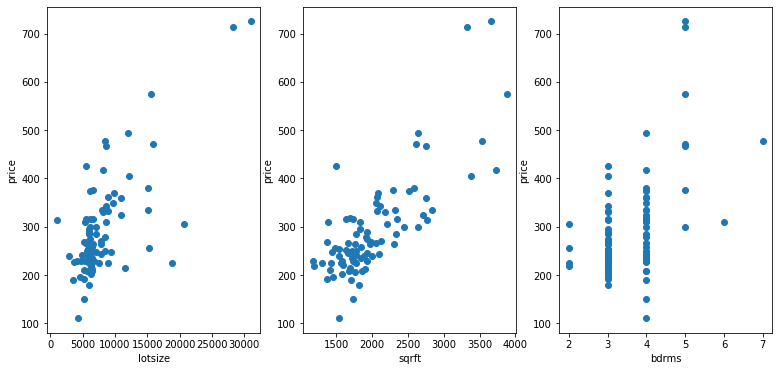

In [13]:
# 使用数据集hprice1
hprice1=pd.read_stata('./data/hprice1.dta')

fig=plt.figure(figsize=(13,6))
ax1=fig.add_subplot(1,3,1)
hprice2=hprice1[hprice1['lotsize']<80000] #去掉了一个极端点，方便观察
plt.scatter(hprice2.lotsize,hprice2.price,axes=ax1)
ax1.set_xlabel('lotsize')
ax1.set_ylabel('price')

ax2=fig.add_subplot(1,3,2)
plt.scatter(hprice1.sqrft,hprice1.price,axes=ax2)
ax2.set_xlabel('sqrft')
ax2.set_ylabel('price')

ax3=fig.add_subplot(1,3,3)
plt.scatter(hprice1.bdrms,hprice1.price,axes=ax3)
ax3.set_xlabel('bdrms')
ax3.set_ylabel('price')

我们发现，lotsize与sqrft的散布情况相对稳定，异方差的情况并不明显；而bdrms就不一样了，当$bdrms=3$时，因变量值分布呈现出往较小值偏移的特征，表现为上面稀疏，下面稠密。而$bdrms=4$时，因变量值的分布则相对对称，这说明price在bdrms上存在异方差的现象！

另一种观测异方差的方法是先进行OLS拟合，并以0为参考基准，观测残差在三个自变量上的表现。

Text(0, 0.5, 'resid')

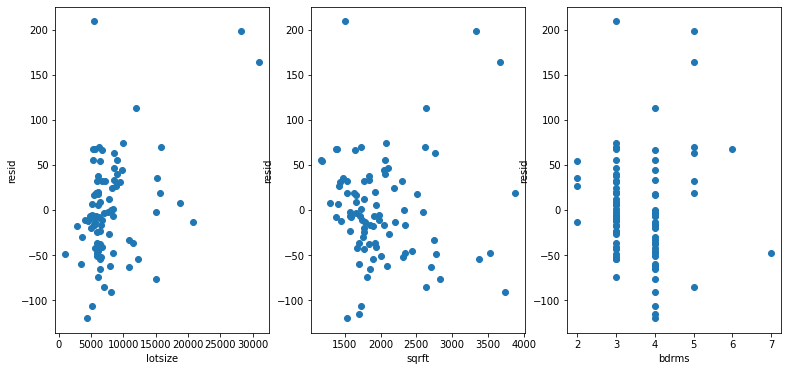

In [14]:
hprice1_lm=sm.formula.ols('price~lotsize+sqrft+bdrms',data=hprice1).fit()
hprice1['resid']=hprice1_lm.resid

# 画图
fig=plt.figure(figsize=(13,6))
ax1=fig.add_subplot(1,3,1)
hprice3=hprice1[hprice1['lotsize']<80000] #去掉了一个极端点，方便观察
plt.scatter(hprice3.lotsize,hprice3.resid,axes=ax1)
ax1.set_xlabel('lotsize')
ax1.set_ylabel('resid')

ax2=fig.add_subplot(1,3,2)
plt.scatter(hprice1.sqrft,hprice1.resid,axes=ax2)
ax2.set_xlabel('sqrft')
ax2.set_ylabel('resid')

ax3=fig.add_subplot(1,3,3)
plt.scatter(hprice1.bdrms,hprice1.resid,axes=ax3)
ax3.set_xlabel('bdrms')
ax3.set_ylabel('resid')


用残差观测的结果得出的结论也是相似的。

### 5.4.2 违背同方差假设的后果

模型形式误设（导致违背MLR.1）以及随机误差的非正态性对模型的影响并不明显，而违反同方差假设的后果就相对严重了:

1. 首先由于MLR.1-MLR.4仍然成立，因此系数估计的无偏性依然成立。
2. 异方差下，OLS估计不再是**最优**线性无偏估计。
3. 异方差下，估计系数的方差计算不再准确，从而影响到标准误的计算，进而影响到t检验与F检验的有效性。

我们注意第三点，并不是说在异方差下我们原先的t检验统计量不再服从t分布了，而是因为t检验统计量中含有标准误，而标准误如果在异方差条件下按照同方差的方式计算，会导致t检验统计量不准确，而如果我们可以将之纠正，我们依旧可以进行t检验与F检验！

有关异方差的解决方法，我们将在下一章节介绍。

# 6. 异方差下的回归分析

我们在上一小节已经知道了异方差导致的两个后果：OLS不再最优、t检验与F检验不再稳健。那么在这一节我们就要针对这两个问题提出解决的方法。

在这一章节我们将学习：

1. 在异方差下如何重新估计标准差/标准误，并进行稳健的推断（假设检验）
2. 如何用假设检验检测数据的异方差性
3. 如何修正OLS估计方法达到最优（广义OLS法-GLS）

我们要分清1与3的区别：方法1仍然建立在OLS估计上，只不过采取了一些措施使得假设检验变得稳健；方法3则是将OLS改进为一种新的估计方法GLS。

## 6.1 异方差稳健的t检验与F检验

所谓稳健方法，就是这种方法不论是在异方差还是同方差下都可以进行使用。

### 6.1.1 重新估计方差

我们回顾一下在同方差假设下$\hat{\beta_j}$的方差估计：
$$
\operatorname{Var}\left(\hat{\beta}_{j}\right)=\frac{\sigma^{2}}{\sum_{i=j}^{n} \hat{r}_{i j}^{2}}=\frac{\sigma^{2}}{S S T_{j}\left(1-R_{j}^{2}\right)}
$$
事实上，这个方差估计有一个更广义的表达
$$
\operatorname{Var}\left(\hat{\beta}_{j}\right)=\frac{\sum \hat{r}_{i j}^{2} \sigma_{i}^{2}}{R S S_{j}^{2}}
$$
在同方差假设下，由于$\sigma_{i}=\sigma$，才有了上面化简了的表达式。然而，在异方差下，我们不能简单地认为$\sigma_{i}=\sigma$，而是对于每一个$\sigma_{i}$都要有一个对应的估计$\hat{\sigma _i}$。那么，对于$\hat{\sigma _i}$，我们要怎么估计它呢？答案是，直接用残差$\hat{u_i}$代替，即$\hat{\sigma _i}=\hat{u_i}$，系数重新估计的方差就变为了
$$
\widehat{\operatorname{Var}\left(\hat{\beta}_{j}\right)}=\frac{\sum \hat{r}_{i j}^{2} \hat{u}_{i}^{2}}{R S S_{j}^{2}}
$$
至此，我们就可以利用新的估计方差进行稳健t检验与F检验了。

### 6.1.2 稳健t检验

对于单参数检验问题，我们使用稳健t检验。

先看单参数检验问题
$$
H_{0}: \beta_{j}=\beta_{j0} \leftrightarrow H_{1}: \beta_{j} \neq \beta_{j 0}
$$
定义t统计量
$$
t=\frac{\hat{\beta}_j-\beta _{j0}}{\mathrm{se}\left( \hat{\beta}_j \right)}\approx N\left( 0,1 \right) 
$$
注意，此时t统计量不再服从t分布，而是服从标准正态分布！（因此需要用到正态分布的p值和分位点，除此以外检验的原理完全不变）。

In [15]:
# 以前面的price1_lm为例
# hprice1_lm=sm.formula.ols('price~lotsize+sqrft+bdrms',data=hprice1).fit()
print('同方差假设下模型的方差估计与推断结果：')
print(hprice1_lm.summary().tables[1])
print('-------------------------------------------')
hprice1_lm_1=sm.formula.ols('price~lotsize+sqrft+bdrms',data=hprice1).fit(cov_type='HC0', use_t=False)
# use_t：稳健t检验是否使用t分布进行推断，False表示拒绝使用t分布，改用标准正态分布
print('异方差假设下模型的稳健方差估计与推断结果：')
print(hprice1_lm_1.summary().tables[1])

同方差假设下模型的方差估计与推断结果：
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.7703     29.475     -0.739      0.462     -80.385      36.844
lotsize        0.0021      0.001      3.220      0.002       0.001       0.003
sqrft          0.1228      0.013      9.275      0.000       0.096       0.149
bdrms         13.8525      9.010      1.537      0.128      -4.065      31.770
-------------------------------------------
异方差假设下模型的稳健方差估计与推断结果：
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.7703     36.284     -0.600      0.549     -92.886      49.346
lotsize        0.0021      0.001      1.691      0.091      -0.000       0.004
sqrft          0.1228      0.017      7.090      0.000       0.089       0.157
bdrms         13.8525      8.284      1.672  

以上结果展示了异方差稳健t检验的结果与普通t检验的结果确实会有不同：lotsize在普通t检验下是显著的，但在稳健t检验中是不显著的。

### 6.1.3 稳健F检验

对于多参数的联合检验，我们使用稳健F检验。

稳健F检验的问题设置与原来的F检验一样，且它们的F检验统计量也完全一样，即
$$
F=\frac{\left(R S S_{r}-R S S_{u r}\right) / q}{R S S_{u r} /(n-k-1)}
$$
只不过，在稳健检验下，F统计量并不严格服从F分布，而是渐进服从自由度为$q$的卡方分布。

我们考虑下述模型
$$
cumgpa=\beta _0+\beta _1sat+\beta _2hsperc+\beta _3tothrs+\beta _4female+\beta _5black+\beta _6white+u
$$
并做假设检验
$$
H_0: \beta _5=\beta _6=0 \leftrightarrow \,\,H_1: H_0\text{不成立}
$$

In [16]:
# 载入数据
gpa3=pd.read_stata('./data/gpa3.dta')
gpa3=gpa3[gpa3['term']==2]

In [17]:
# 直接训练无约束模型，并采用稳健估计训练
gpa3_lm=sm.formula.ols('cumgpa~sat+hsperc+tothrs+female+black+white',data=gpa3).fit(cov_type='HC0')

hypotheses='(black=0),(white=0)' # 另一种做联合检验的形式，直接将原假设写出来
gpa3_lm.wald_test(hypotheses,use_f=True,scalar=False)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.74779698]]), p=0.47414427215551025, df_denom=359, df_num=2>

在上面的报告中，F值为0.74779698，p值为0.47414427215551025，显然，不能拒绝原假设。

## 6.2 异方差的诊断

尽管异方差稳健的t、F检验适用范围更广，但是如果数据不存在异方差，则传统OLS估计及其假设检验依然是最优的；此外，如果我们能确定存在异方差且可以估计出异方差的形式，那么我们可以获得比OLS估计更好的估计方法。而它们的前提都是我们可以准确地判断出数据是否存在异方差。

在前面的学习中，我们通过散点图的方法粗略地判断模型是否存在异方差，但是这样的判断方法过于主观，我们需要一种可靠客观的诊断方法。

异方差检验的种类非常多，有的检验只检验方差是否“恒定”，而不检验方差是否与自变量无关，即方差是某些自变量的函数$\sigma =\sigma \left( x \right)$。事实上，比起纯粹地知晓方差是否恒定，我们更关心后者，这是因为如果方差确实是某个自变量的函数，那么我们就可以采用广义OLS估计法（也就是GLS）进行更有效地估计。

关于检验方差是否与自变量无关的方法，最常用的便是BP异方差检验与White异方差检验。

### 6.2.1 BP异方差检验

**· 检验思想**

我们取原假设为：假定同方差假设正确，即
$$
\operatorname{Var}\left(u \mid x_{1}, \cdots, x_{k}\right)=\sigma^{2}
$$
由于MLR.2假设：$E\left(u \mid x_{1}, \cdots, x_{k}\right)=0$的成立，则同方差假设等价为
$$
E\left( u^2\mid x_1,\cdots ,x_k \right) =\sigma ^2
$$
这个假设说明的是$u^2$的条件均值应当为一个常数而不是一个与自变量$x_j$有关的函数。我们在前面提到过，回归的本质是条件均值建模，而这个假设刚好就是有关$u^2$条件均值的假设，于是我们可以**根据我们实际要检验的问题构建线性回归模型**，并将检验问题等价为模型系数的显著性检验。

BP检验的实质是检验异方差与所有自变量的一次项无关，这就等价于对一个以$u^2$为因变量，以$x_j$为自变量的线性回归模型
$$
u^{2}=\delta_{0}+\delta_{1} x_{1}+\delta_{2} x_{2}+\cdots+\delta_{k} x_{k}+v
$$
做全部变量系数的联合显著性检验，于是原假设变为
$$
\mathrm{H}_{0}: \delta_{1}=\delta_{2}=\cdots=\delta_{k}=0
$$
如果原假设被拒绝，就意味着存在一种与某自变量一次项相关的异方差。


**· BP检验的步骤（了解即可）**

1. 使用OLS法估计模型
$$
y \sim x_{1}+x_{2}+\cdots+x_{k-1}+x_{k}
$$
获得残差的平方$\hat{u}^2$

2. 使用OLS估计法估计模型
$$
\hat{u}^2 \sim x_{1}+x_{2}+\cdots+x_{k-1}+x_{k}
$$

3. 对所有变量系数做联合检验，可用F检验或大样本LM检验。

**· 用python实现BP检验**

依旧以前面的hprice1_lm为例，检验price~lotsize+sqrft+bdrms是否存在异方差。

In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan

# 直接输出
# hprice1_lm=sm.formula.ols('price~lotsize+sqrft+bdrms',data=hprice1).fit()
hprice1_lm_reg=sm.formula.ols('price~lotsize+sqrft+bdrms',data=hprice1) # 相比于hprice1_lm，他没有fit()
het_breuschpagan(hprice1_lm.resid,hprice1_lm_reg.exog)


(14.092385504350233,
 0.0027820595556890993,
 5.338919363241416,
 0.0020477444209360787)

In [19]:
# 定义一个输出bp检验的函数
def bp_test(res, X):
    result_bp_test = sm.stats.diagnostic.het_breuschpagan(res, X)
    bp_lm_statistic = result_bp_test[0]
    bp_lm_pval = result_bp_test[1]
    bp_F_statistic= result_bp_test[2]
    bp_F_pval = result_bp_test[3]
    bp_test_output=pd.Series(result_bp_test[0:4],index=['bp_lm_statistic','bp_lm_pval','bp_F_statistic','bp_F_pval'])    
    return bp_test_output

bp_test(hprice1_lm.resid,hprice1_lm_reg.exog)

bp_lm_statistic    14.092386
bp_lm_pval          0.002782
bp_F_statistic      5.338919
bp_F_pval           0.002048
dtype: float64

正如我们猜想的那样，确实存在异方差现象。

### 6.2.2 White异方差检验

BP检验考虑的是是否存在与变量的一次项相关的异方差，而White检验则增加了对所有变量二次项以及交互项的考察。

假若模型包含三个变量，BP检验所检验的模型是
$$
u^2\sim x_1+x_2+x_3
$$
而White检验所检验的模型是
$$
u^2\sim x_1+x_2+x_3+{x_1}^2+{x_2}^2+{x_3}^2+x_1x_2+x_1x_3+x_2x_3
$$
White检验虽然考虑的问题范围更广，但是由于回归元个数指数级增长，模型自由度相比于BP检验大大降低，对于自变量较多的情况，White检验可能并不如BP检验合适。

In [20]:
from statsmodels.stats.diagnostic import het_white

# White检验函数在python上的使用与bp检验完全一样

def white_test(res, X):
    result_bp_test = sm.stats.diagnostic.het_white(res, X)
    bp_lm_statistic = result_bp_test[0]
    bp_lm_pval = result_bp_test[1]
    bp_F_statistic= result_bp_test[2]
    bp_F_pval = result_bp_test[3]
    white_test_output=pd.Series(result_bp_test[0:4],index=['white_lm_statistic','white_lm_pval','white_F_statistic','white_F_pval'])    
    return white_test_output
    
white_test(hprice1_lm.resid,hprice1_lm_reg.exog)

white_lm_statistic    33.731658
white_lm_pval          0.000100
white_F_statistic      5.386953
white_F_pval           0.000010
dtype: float64

## 6.3 广义最小二乘法

回归存在异方差的另一种解决方法，就是根据异方差的具体形式使用广义的最小二乘法，对模型进行重新估计。对于这种解决方法，变量系数的估计也会发生变化，但是在异方差情形下，它比传统的OLS估计法更优！

我们提到“根据异方差的具体形式”，是指异方差可以用自变量的函数被表达出来。如果它能被我们找出来，我们就可以是加权最小二乘估计WLS；如果由于函数形式复杂而无法被判断出来，我们则使用可行的广义最小二乘估计FGLS。

接下来我们就来学习一下这两种方法吧！

### 6.3.1 加权最小二乘法

加权最小二乘法的原理非常简单。

假设异方差的形式除去一个常数外是已知的，即
$$
\operatorname{Var}(u \mid x)=\sigma^{2} h(x)
$$
那么如果我们在原模型两边同除以$\frac{1}{\sqrt{h\left( x \right)}}$，即
$$
\frac{y}{\sqrt{h\left( x \right)}}=\frac{\beta _{0}^{*}}{\sqrt{h\left( x \right)}}+\beta _{1}^{*}\frac{x_1}{\sqrt{h\left( x \right)}}+\cdots +\beta _{k}^{*}\frac{x_k}{\sqrt{h\left( x \right)}}+\frac{u}{\sqrt{h\left( x \right)}}
$$

并将带有$\frac{1}{\sqrt{h\left( x \right)}}$的自变量与随机误差视作是新的变量与随机误差，则问题就是同方差情形了，我们可以使用OLS估计。

我们使用一个简单的例子教会大家如何鉴别简单的异方差形式，并用statsmodels包中的wls函数进行wls估计。

**· Example13.** 我们想研究27家企业主管人数Y与工人人数X的关系。由于只有一个自变量，一开始我们可以考虑简单线性回归模型
$$
Y=\beta _0+\beta _1X+u
$$

In [21]:
# 载入数据集
data=pd.read_table('./data/P176.txt')
data.head()

,X,Y
0,294,30
1,247,32
2,267,37
3,358,44
4,423,47


在判断异方差函数的形式上，可视化发挥着重要的作用。我们可以采用之前画散点图的办法，初步观测样本分布的情况。

bp_lm_statistic    16.028369
bp_lm_pval          0.000062
bp_F_statistic     36.522300
bp_F_pval           0.000003
dtype: float64
----------------------------------
white_lm_statistic    2.113448e+01
white_lm_pval         2.574574e-05
white_F_statistic     4.323809e+01
white_F_pval          1.104869e-08
dtype: float64


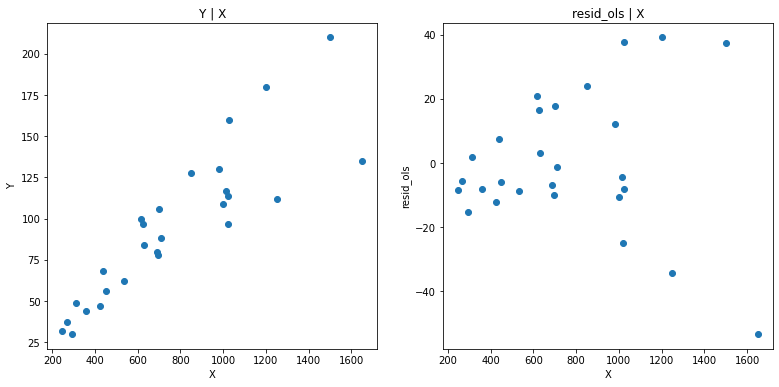

In [22]:
# 直接看Y与X的散点图
fig=plt.figure(figsize=(13,6))
ax1=fig.add_subplot(1,2,1)
plt.scatter(data.X,data.Y,axes=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Y | X')

# 查看ols估计的残差与X的散点图
data_lm=sm.formula.ols('Y~X',data=data).fit()
ax2=fig.add_subplot(1,2,2)
plt.scatter(data.X,data_lm.resid,axes=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('resid_ols')
ax2.set_title('resid_ols | X')

# 使用BP检验
data_lm_reg=sm.formula.ols('Y~X',data=data)
print(bp_test(data_lm.resid,data_lm_reg.exog))
print('----------------------------------')
# 使用White检验
data_lm_reg=sm.formula.ols('Y~X',data=data)
print(white_test(data_lm.resid,data_lm_reg.exog))

bp检验与White检验均表示，回归确实存在明显的异方差线性。且根据散点图，我们可以看到随着X的增大，样本的分布越来越分散，即方差越来越大。我们设想：方差可能与X的二次项成正比（一次项也有可能，言之有理即可），于是我们假定
$$
\operatorname{Var}(u \mid x)=\sigma^{2} x^{2}
$$

In [23]:
data_lm_wls=sm.formula.wls('Y~X',weights=1/data.X**2,data=data).fit()
# 注意：weights传入的是一个数组，不是一个“表达式”。如果方差函数为h(x)，则要传入1/h(x)的数组
print(data_lm.summary().tables[1])
print(data_lm_wls.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.4481      9.562      1.511      0.143      -5.245      34.141
X              0.1054      0.011      9.303      0.000       0.082       0.129
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8033      4.570      0.832      0.413      -5.608      13.215
X              0.1210      0.009     13.445      0.000       0.102       0.140


我们对比一下两种估计方法的结果。加入我们对方差的假设是正确的，wls估计的系数标准误要小于ols估计的系数标准误，这说明wls在异方差下表现优于ols估计。

### 6.3.2 可行的广义最小二乘法

WLS估计法要求我们知晓$h(x)$的具体形式，而在大多数情况下，$h(x)$的形式是难以通过观察得出的，这个时候我们就需要使用一种方法估计出$h(x)$的形式，再使用wls估计法求解模型。这种方法又称为FGLS。

**· 如何估计$h(x)$**

FGLS将$h(x)$假设为
$$
h(x)=\exp \left(\delta_{0}+\delta_{1} x_{1}+\cdots+\delta_{k} x_{k}\right)
$$
则条件方差的表达式就有
$$
\mathrm{Var(}u\mid x)=E\left( u^2\mid x \right) =\sigma ^2\exp \left( \delta _0+\delta _1x_1+\cdots +\delta _kx_k \right) 
$$
进而有
$$
E\left( u^2\mid x \right) =\sigma ^2\exp \left( \delta _0+\delta _1x_1+\cdots +\delta _kx_k \right) \Rightarrow \log \left( u^2 \right) \sim x_1+\cdots +x_k
$$
也就是说，我们先用OLS估计求解一个以$\log \left(\hat{u}^{2}\right)$为因变量的线性回归模型，再将该模型进行指数化处理，便可以得到$h(x)$的估计形式了。

我们总结出以下步骤：

1. 做回归$y \sim x_{1}+\cdots x_{k}$，得到残差$\hat{u}$
2. 做回归$\log \left(\hat{u}^{2}\right) \sim x_{1}+\cdots+x_{k}$，得到拟合值$\hat{g}$
3. 计算函数$\hat{h}=\exp (\hat{g})$
4. 以$1/\hat{h}$做权重，用wls估计模型$y \sim x_{1}+\cdots x_{k}$


**· 用 python实现FGLS**

statsmodels没有直接进行FGLS的函数，我们需要手动估计$h(x)$。我们考虑下面的模型，用FGLS对其进行估计
$$
\text { cigs }=\beta_{0}+\beta_{1} \log (\text { income })+\beta_{2} \log (\text { cigpric })+\beta_{3} \text { educ }+\beta_{4} a g e+\beta_{5} \text { age }{ }^{2}+\beta_{6} \text { restaurn }+u
$$

In [24]:
smoke=pd.read_stata('./data/smoke.dta')
smoke.head()

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric
0,16.0,60.506001,1.0,46.0,20000.0,0.0,0.0,9.903487,2116.0,4.102743
1,16.0,57.882999,1.0,40.0,30000.0,0.0,0.0,10.308950,1600.0,4.058424
2,12.0,57.664001,1.0,58.0,30000.0,3.0,0.0,10.308950,3364.0,4.054633
3,13.5,57.882999,1.0,30.0,20000.0,0.0,0.0,9.903487,900.0,4.058424
4,10.0,58.320000,1.0,17.0,20000.0,0.0,0.0,9.903487,289.0,4.065945


In [25]:
# 先进行ols估计
smoke_lm_ols=sm.formula.ols('cigs~np.log(income)+np.log(cigpric)+educ+age+I(age**2)+restaurn',data=smoke).fit()
smoke['resid']=smoke_lm_ols.resid

# 进行辅助回归
smoke_lm_log=sm.formula.ols('np.log(resid**2)~np.log(income)+np.log(cigpric)+educ+age+I(age**2)+restaurn',data=smoke).fit()
h_hat=np.exp(smoke_lm_log.fittedvalues)

# 进行wls检验
smoke_lm_wls=sm.formula.wls('cigs~np.log(income)+np.log(cigpric)+educ+age+I(age**2)+restaurn',weights=1/h_hat,data=smoke).fit()
print(smoke_lm_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                   cigs   R-squared:                       0.113
Model:                            WLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     17.06
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.32e-18
Time:                        11:21:33   Log-Likelihood:                -3207.8
No. Observations:                 807   AIC:                             6430.
Df Residuals:                     800   BIC:                             6462.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.6355     17.803     

# 作业

## 作业1：含二次项/对数项模型的讨论

我们想要探究婴儿出生的体重与何种因素相关，数据集为bwght2.dta，本次习题所使用的变量解释如下：

因变量：
<br>
· bwght：婴儿出生体重

自变量：
<br>
· npvis：母亲产前检查次数
<br>
· mage：母亲年龄

**使用python进行实操并回答以下问题**

（1）：使用OLS估计方程
$$
\log (b w g h t)=\beta_{0}+\beta_{1} n p v i s+\beta_{2} n p v i s^{2}+u
$$
输出报告表，并回答：自变量npvis的二次项是否显著？自变量npvis是否对因变量有显著影响？

（2）：基于（1）的方程，我们认为最大化log(bwght)的产前检查次数npvis约为24，其理论依据是什么？

（3）：按照这个模型的结果，在24次产前检查后婴儿出生体重会下降，这是为什么？你认为这有实际意义吗？这蕴含了一个含二次项变量模型的常见陷阱，请仔细思考！

（4）：在模型中加入母亲年龄变量及其二次形式。回答：保持npvis不变，母亲在什么生育年龄时，孩子出生体重最大？大于这个年龄时，孩子出生体重下降，这是否具有实际意义呢？请结合问题（3）思考这一问题。

（5）：（4）中的模型能否解释log(gwght)大部分变异？


## 作业2：异方差模型的讨论

紧接着example13（主管人数与工人人数间关系的问题），我们对异方差问题进行更进一步的探讨。

**使用python进行实操并回答以下问题**

（1）：在假设方差形式为$\operatorname{Var}(u \mid x)=\sigma^{2} x^{2}$并进行wls估计后，比较wls估计与ols估计的残差图，回答：异方差消除了吗？

（2）：使用FGLS估计对该模型进行重新估计，观察残差图并回答：异方差消除了吗？

（3）：画出log(Y)与X的散点图，观察方差的状况，说说你的发现；根据散点图的情况，请大胆假设一个你认为正确的模型。

（4）：考虑新模型
$$
\log (Y)=\beta_{0}+\beta_{1} X+\beta_{2} X^2+u
$$
使用ols估计该模型，并画出残差散点图，说说你的发现

（5）：综合以上四个问题，谈谈你对纠正模型异方差的见解。
